## Data Cleaning

This notebook will attempt to accomplish the following
- Missing data
- Scaling and Normalization (applies to continuous variables)
- Removing Duplicates
- Outlier detection
- Encoding categorical variables
- Feature engineering

In [37]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import stats
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.decomposition import PCA


In [38]:
# Define column names
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'income']

# Load the dataset
data = pd.read_csv(f'{os.getcwd()}/ProjectData/adult/adult.data', header=None, names=columns)
print(data.shape)
data.head()


(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


---
## Removing instances with missing features

 This block of code performs data preprocessing on the 'adult' dataset.
 Removing cells with missing features, removing duplicate rows, detecting and removing outliers using the IQR method.
 Selecting numeric columns for scaling, applying standardization (Z-score normalization),
 and saving the processed data to new CSV files.


In [39]:

# Strip leading and trailing whitespace from all columns
data = data.map(lambda x: x.strip() if isinstance(x, str) else x)

# Replace '?' with NaN and remove rows with NaN values
cleaned_data = data.replace('?', pd.NA).dropna()

# Remove duplicate rows
cleaned_data.drop_duplicates(inplace=True)

# Function to detect outliers using IQR
def detect_outliers_iqr(df):
    outliers_indices = []
    for col in df.select_dtypes(include=[float, int]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outliers_indices.extend(outliers_col)
    return list(set(outliers_indices))

# Detect outliers
outliers = detect_outliers_iqr(cleaned_data)


# Create a DataFrame excluding outliers
cleaned_data_no_outliers = cleaned_data.drop(index=outliers)

# Print the shapes of the original, cleaned, and outliers datasets
print(f"Original data shape: {data.shape}")
print(f"Cleaned data shape: {cleaned_data.shape}")
print(f"Data shape after removing outliers IQR: {cleaned_data_no_outliers.shape}")
print(f"Outliers dropped: {len(outliers)}")

# Select only the numeric columns for scaling
numeric_cols = cleaned_data_no_outliers.select_dtypes(include=['float64', 'int64']).columns
numeric_data = cleaned_data_no_outliers[numeric_cols]

# Standardization (Z-score normalization)
scaler = StandardScaler()
standardized_data = scaler.fit_transform(numeric_data)
standardized_df = pd.DataFrame(standardized_data, columns=numeric_cols)

# Save the cleaned and standardized data
standardized_df.to_csv(f'{os.getcwd()}/ProjectData/adult/standardized_adult.data', index=False)
cleaned_data_no_outliers.to_csv(f'{os.getcwd()}/ProjectData/adult/clean_adult.data', index=False)


Original data shape: (32561, 15)
Cleaned data shape: (30139, 15)
Data shape after removing outliers IQR: (18442, 15)
Outliers dropped: 11697


In [40]:


# Load the cleaned data
data = pd.read_csv(f'{os.getcwd()}/ProjectData/adult/clean_adult.data')

# Preprocess the data

# Encode the categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Split the data into features (X) and target (y)
X = data.drop('income', axis=1)
y = data['income']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on the testing set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8145838980753591
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      2885
           1       0.67      0.29      0.40       804

    accuracy                           0.81      3689
   macro avg       0.75      0.62      0.65      3689
weighted avg       0.80      0.81      0.78      3689



In [41]:
# Fit the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print(rf_model.score)


Accuracy: 0.8359989156953104
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      2885
           1       0.67      0.50      0.57       804

    accuracy                           0.84      3689
   macro avg       0.77      0.71      0.73      3689
weighted avg       0.82      0.84      0.83      3689

<bound method ClassifierMixin.score of RandomForestClassifier(random_state=42)>


In [42]:
# Load the cleaned data
data = pd.read_csv(f'{os.getcwd()}/ProjectData/adult/clean_adult.data')

# Preprocess the data

# Encode the categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Split the data into features (X) and target (y)
X = data.drop('income', axis=1)
y = data['income']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = gb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}\n\n")
print("_________________________________________")
print("Classification Report:\n", class_report)


Accuracy: 0.85


_________________________________________
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      2885
           1       0.73      0.47      0.57       804

    accuracy                           0.85      3689
   macro avg       0.80      0.71      0.74      3689
weighted avg       0.84      0.85      0.83      3689



# Income Prediction

Objective of this project is to use classification models to predict if a person's income is less than or greater than 50K

## Dataset

#### Load the dataset

In [43]:
# Load the dataset
columns =['age', 'workclass', 'fnlwgt', 'education', 'educationnum','maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'capitalgain', 'capitalloss', 'hoursperweek', 'nativecountry','income']
adult = pd.read_csv(f'{os.getcwd()}/ProjectData/adult/adult.data', header=None, names=columns)
print(adult.shape)
adult.head()

(32561, 15)


,age,workclass,fnlwgt,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Number of categorical variables : 9  
Number of numerical variables:  6

In [44]:
num_features =['age','fnlwgt','educationnum','capitalgain', 'capitalloss', 'hoursperweek']
cat_features =['workclass', 'education', 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'nativecountry']
target_feature = ['income']

1. The dataset has a total of 32561 records
2. The dataset has 14 independent variable and one dependent variable
3. The dataset has 8 categorical features - workclass, education, marital-status, occupation, relationship, race, sex, native-country
4. The dataset has 6 numerical features - age,fnlwgt,education-num,capital-gain, capital-loss, hours-per-week
5. Age -   
6. workclass -   
7. fnlwgt -
8. education -
9. education-num -
10. marital-status -
11. occupation -
12. relationship -
13. race -
14. sex -
15. capital-gain -
16. capital-loss -
17. hours-per-week -
18. native-country -  
19. income - This is the target column to predict. Takes value >=50K or <=50K


## Data Cleaning & Data Preparation

#### Handling Missing data

#### Encoding Categorical Variables

In [45]:
# Encoding Categorical Variables
def encode_columns(df, cat_features):
    df_encoded = df.copy()  # Create a copy of the DataFrame to work on
    le = LabelEncoder()
    for col in cat_features:
        df_encoded[col] = le.fit_transform(df_encoded[col])  # Convert to string to handle any type of data
    #df_encoded[target_col] = le.fit_transform(df_encoded[target_col])  # Encode the target column
    return df_encoded

# Encode the categorical and target columns
adult_encoded = encode_columns(adult, cat_features)
adult_encoded = encode_columns(adult_encoded, target_feature)

#### Train Test Split

In [46]:
# Split data into features and target
X = adult_encoded.drop('income', axis=1)
y = adult_encoded['income']

In [47]:
# Train test split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
def prepareData(X):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA to reduce dimensionality for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca


### Utility Functions

In [49]:
# Drop all the features which has correlation 
def dropFeatures(threshold, df):
    correlations = df.corr()['income'].abs()
    cols_drop = correlations[correlations < threshold].index
    train = X_train.drop(cols_drop, axis=1)
    test = X_test.drop(cols_drop, axis=1)
    return train, test

In [50]:
# calculate proportion for each colunmn
def percent_of_total(column):
    percent_of_total = adult.groupby([column, target_col[0]]).size().unstack()
    for i in range(len(percent_of_total)):
        percent_of_total.iloc[i,:] = percent_of_total.iloc[i,:]/sum(percent_of_total.iloc[i,:])
    return percent_of_total*100

## Exploratory Data Analysis

### Univariate Analysis

In [51]:
# Descriptive statistics for adult dataset
adult.describe(include='all')

,age,workclass,fnlwgt,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,income
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


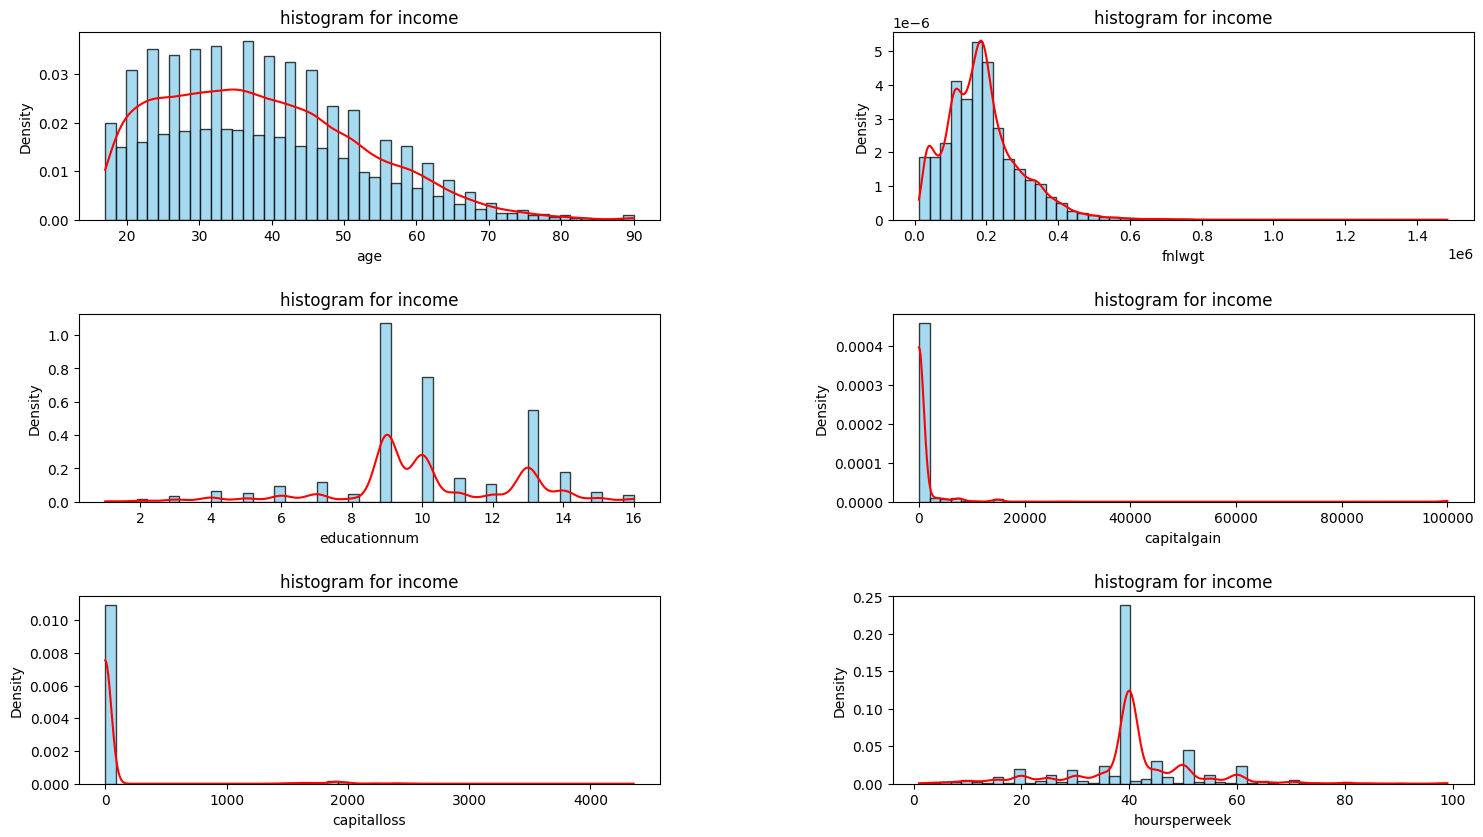

In [52]:
# create histogram with KDE plot for all teh numerical features
fig, ax = plt.subplots(3, 2, figsize=(18, 8))
plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=0.5, wspace=0.4)
ax = ax.flatten()
for i,col in enumerate(num_features):
    kde = stats.gaussian_kde(adult[col])
    x = np.linspace(adult[col].min(), adult[col].max(), 1000)
    ax[i].plot(x, kde(x), color='red')
    ax[i].hist(adult[col], bins=50, density=True, alpha=0.75, color='skyblue', edgecolor='black')
    ax[i].set_title(f'histogram for income')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Density')
#fig.delaxes(ax[i+1])

#### Analysis of numberical columns

1. Age is positively skewed with mean slightly greater than median
2. Fnlwgt: Fnlwgt is significantly skewed to right with Kurtosis value of 6.6 and skewness value of 1.5
3. Captial gain: with high skewness value and very high kurtosis value, ths shows capital gain is heavily skewed to right with significant outliers. The Q1, median, and Q3 are all 0, indicating that the majority of the data points are 0
4. Captial loss: with high skewness value and very high kurtosis value, ths shows capital gain is heavily skewed to right with significant outliers. The Q1, median, and Q3 are all 0, indicating that the majority of the data points are 0
5. The hours per week is only slightly skewed and mostly follows a normal distribution

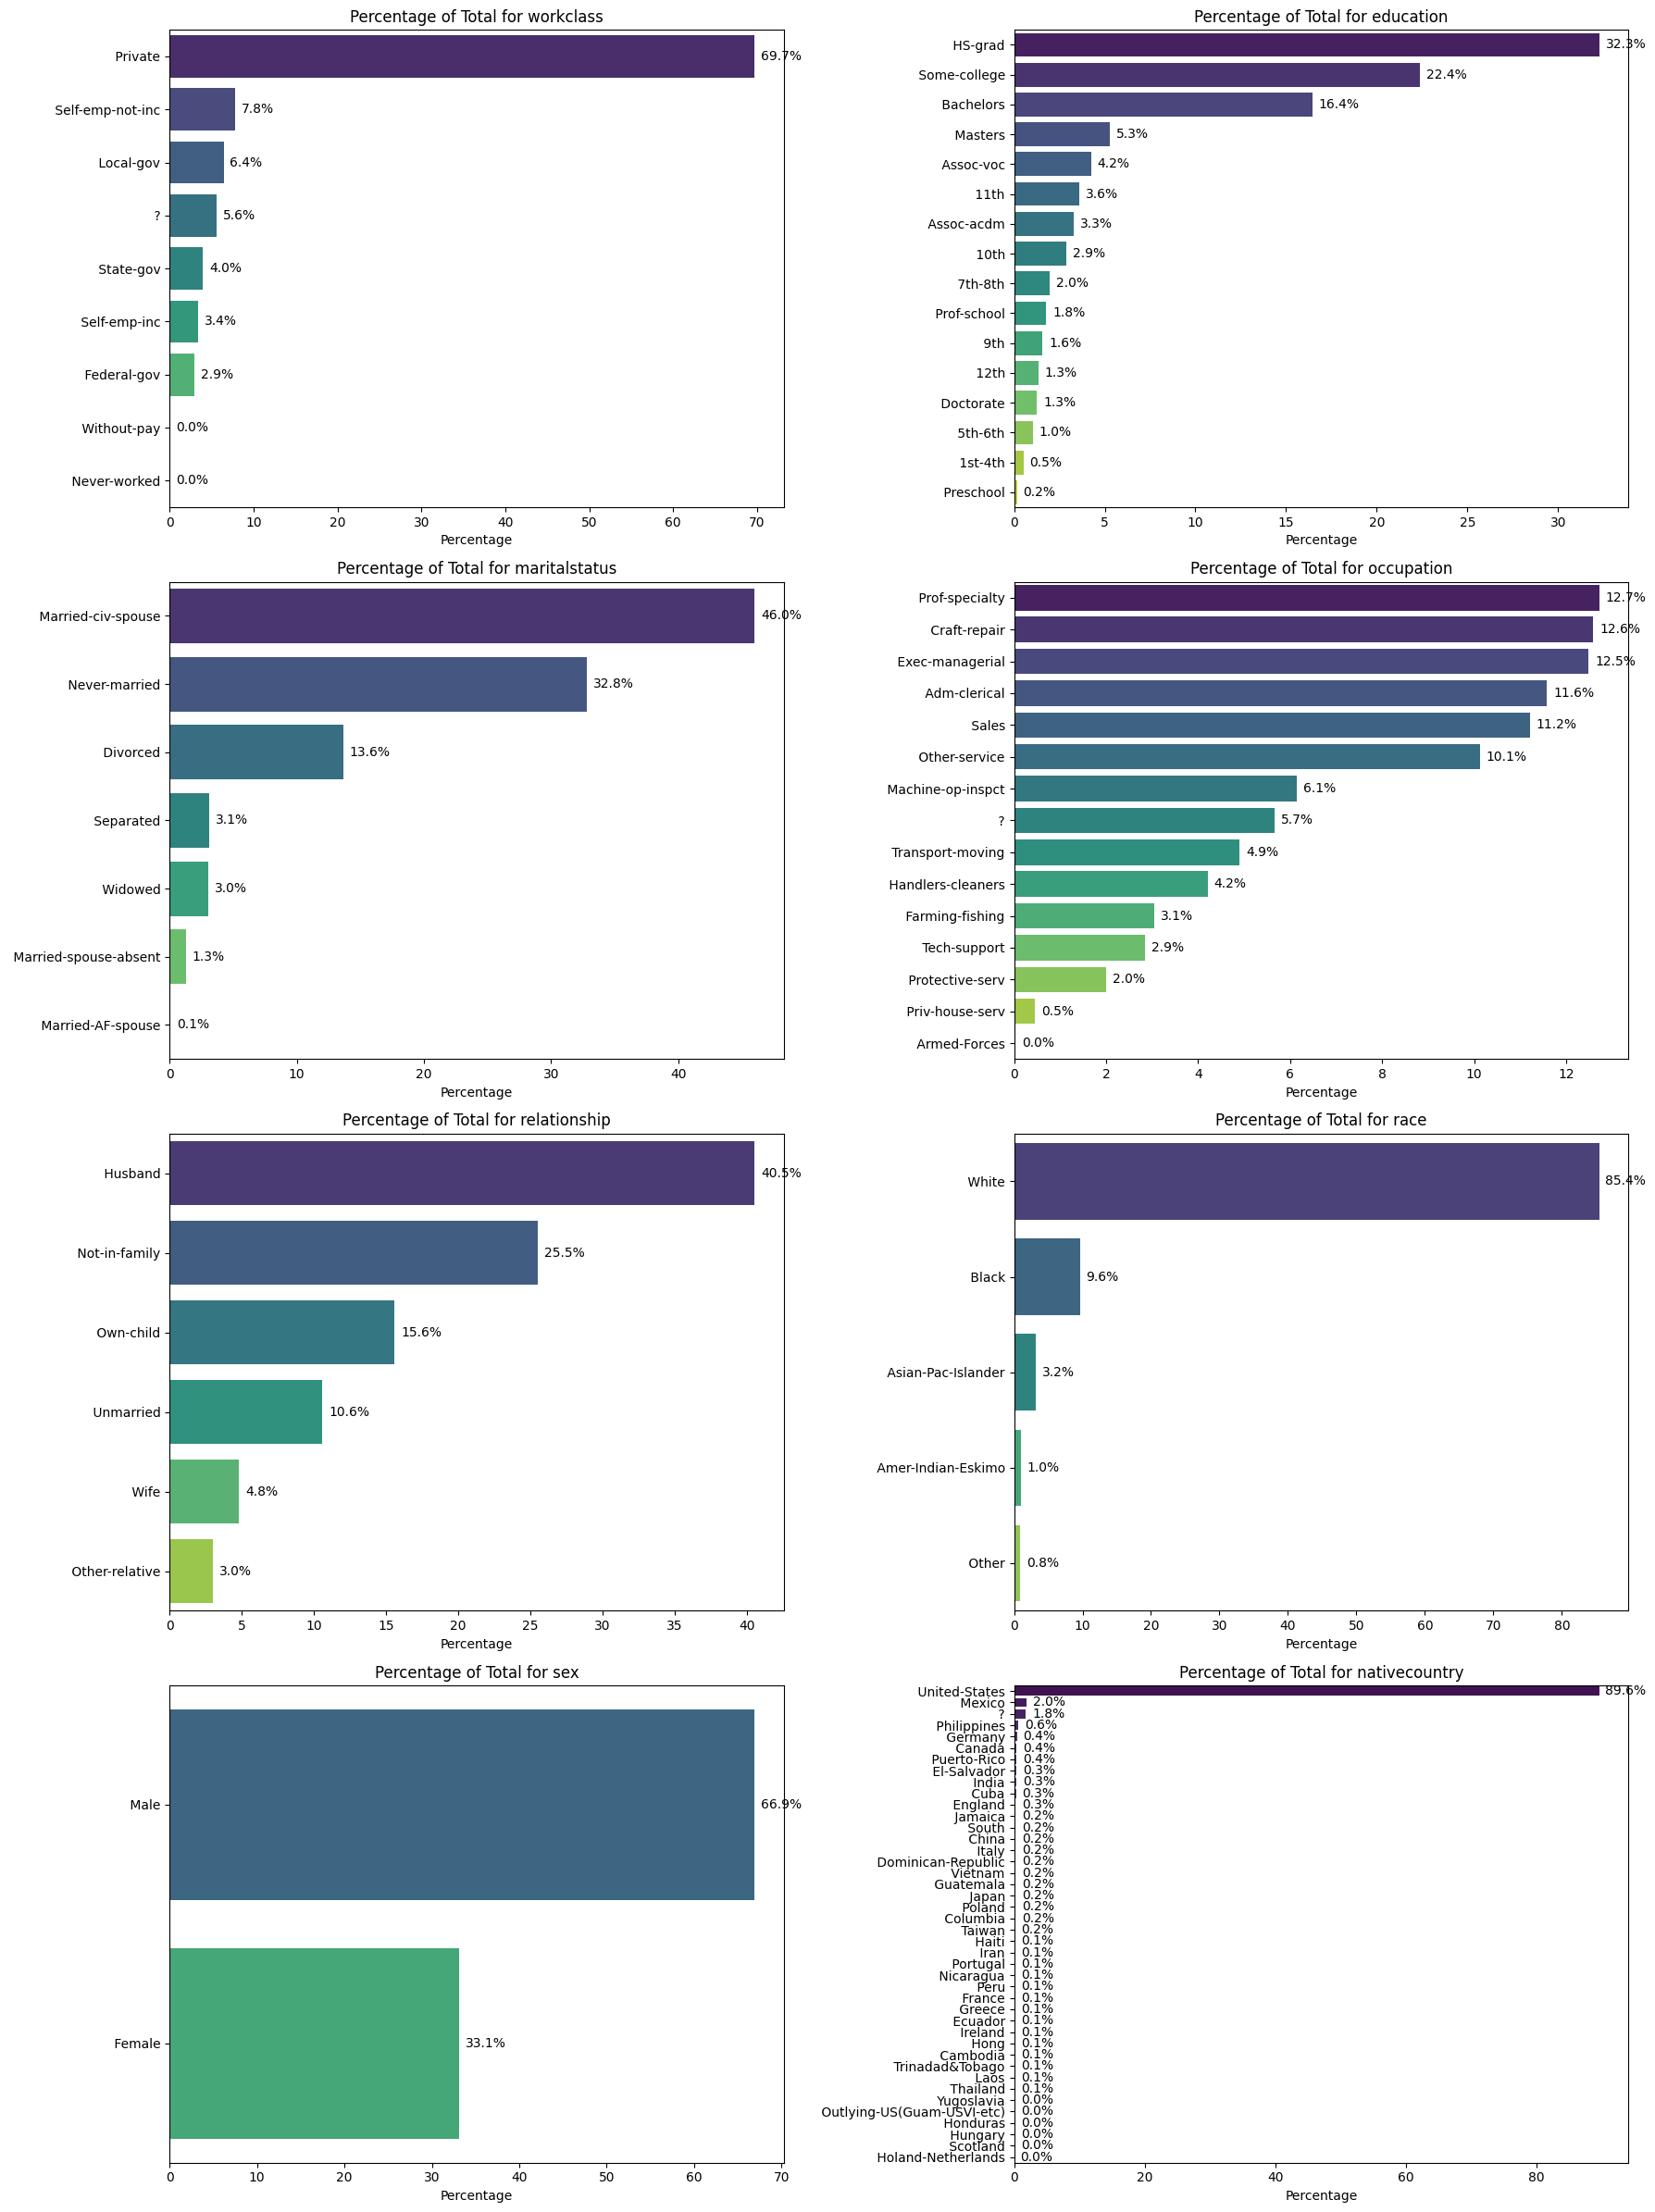

In [53]:

# Define the percent_of_total function
def percent_of_total(df, second_column):
    value_counts = df[second_column].value_counts()
    percent_total = value_counts / sum(value_counts)
    return percent_total * 100

# Setting up the subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 24))
axes = axes.flatten()

# Plotting horizontal bar plots
for ax, col in zip(axes, cat_features):
    percent_total = percent_of_total(adult, col)
    bars = sns.barplot(x=percent_total.values, y=percent_total.index, hue=percent_total.index, ax=ax, palette='viridis', legend=False)
    
    # Annotating the bars with percentage values
    for bar, perc in zip(bars.patches, percent_total.values):
        ax.annotate(f'{perc:.1f}%',
                    xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                    xytext=(5, 0),  # 5 points horizontal offset
                    textcoords='offset points',
                    ha='left', va='center')
    
    ax.set_title(f'Percentage of Total for {col}')
    ax.set_xlabel('Percentage')
    ax.set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()


1. Private workclass category represents 70% proportion of the total dataset
2. 90% proportion of total dataset has data for United states. Other countries has relatively small proportion of data.
3. Distribution of rest of the categories are highly fragmented, with no dominant category

# Bivariate Analysis

In [54]:
# Find correlations between income and other features
correlations = adult_encoded.corr()['income'].abs()
correlations

age              0.234037
workclass        0.051604
fnlwgt           0.009463
education        0.079317
educationnum     0.335154
maritalstatus    0.199307
occupation       0.075468
relationship     0.250918
race             0.071846
sex              0.215980
capitalgain      0.223329
capitalloss      0.150526
hoursperweek     0.229689
nativecountry    0.015840
income           1.000000
Name: income, dtype: float64

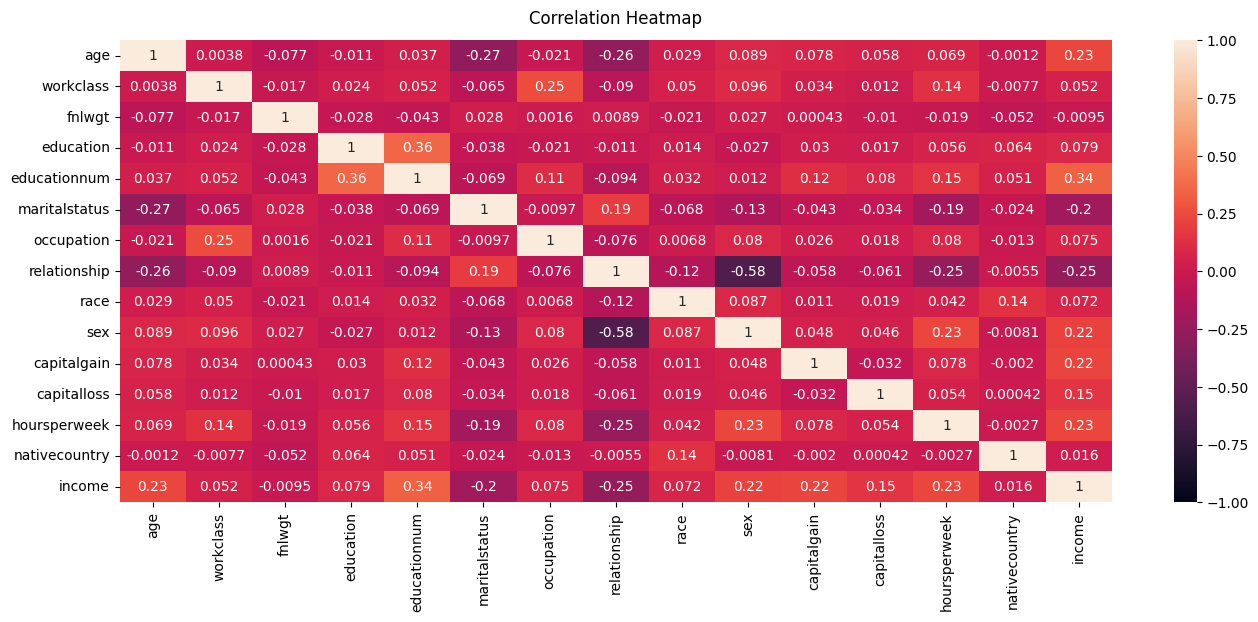

In [55]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Plot the heatmap for correlation data of all features against income
heatmap = sns.heatmap(adult_encoded.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e  
https://towardsdatascience.com/seaborn-heatmap-for-visualising-data-correlations-66cbef09c1fe

In [79]:
def percent_of_total(column):
    percent_of_total = adult.groupby([column, target_feature[0]]).size().unstack()
    percent_of_total = percent_of_total.astype(float)  # Cast to float to ensure compatibility
    for i in range(len(percent_of_total)):
        percent_of_total.iloc[i, :] = percent_of_total.iloc[i, :] / sum(percent_of_total.iloc[i, :])
    return percent_of_total

1. Number of years of education and captial gain has a strong positive correlation against income.
2. age, ccapital-loss,and hours-per-week has moderate positive correlations and has a significant role in determining the income
4. Education, occupation, race, workclass, native-country has a weak positive correlation
5. Relationship, marital-status has weak correlations. This suggests that certain marital statuses or relationship types may be associated with slightly lower incomes.
6. Fnlwgt has very weak negative correlation and may not have any inflluence on income.

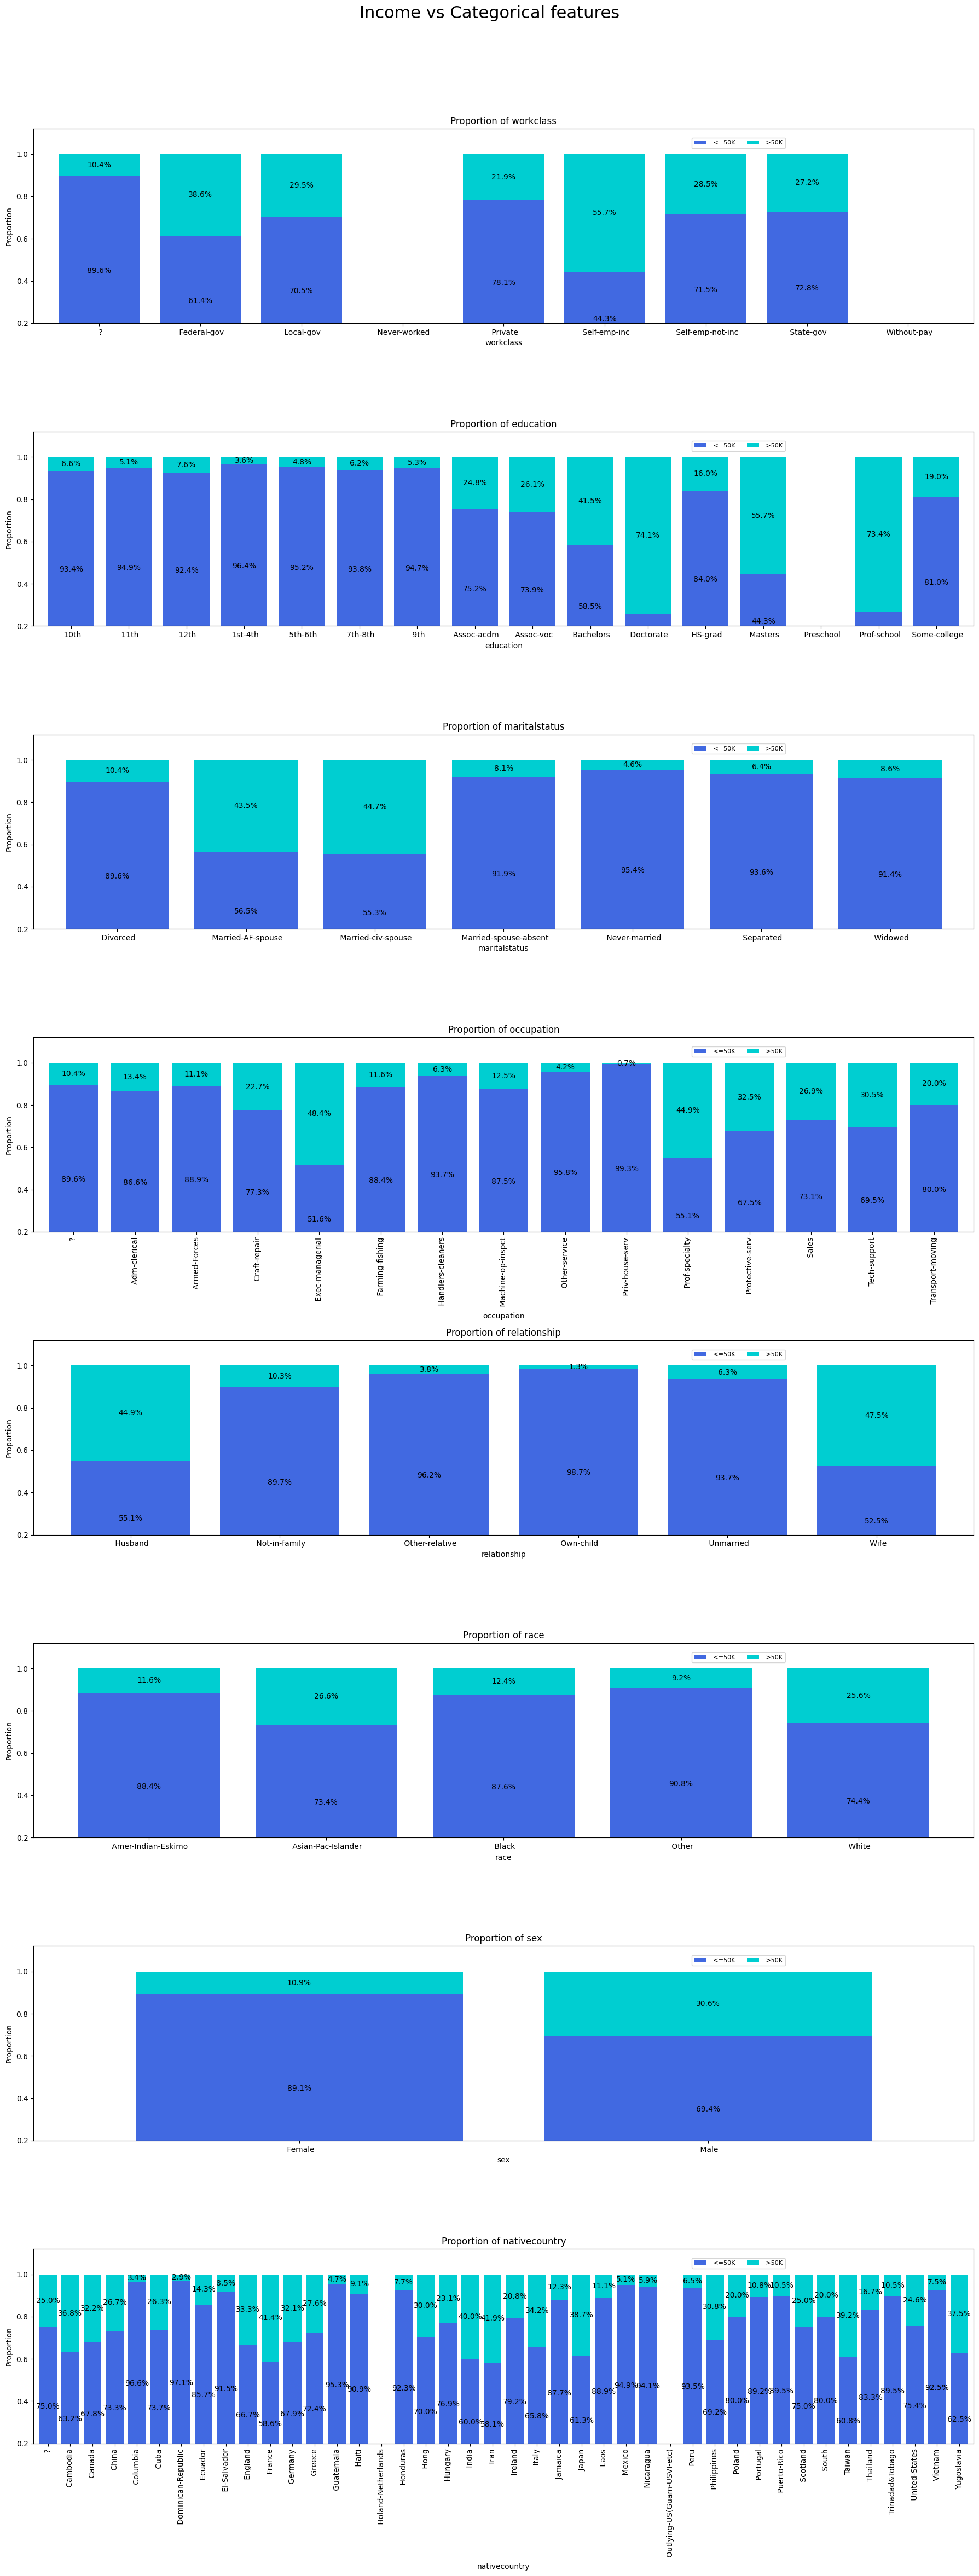

In [80]:
fig, ax = plt.subplots(8, 1, figsize=(18, 48))
ax = ax.flatten()
cmp = ListedColormap(['royalblue', 'darkturquoise'])
for i,col in enumerate(cat_features):
    proportion = percent_of_total(col)
    bars = proportion.plot(kind='bar', ax=ax[i], stacked=True, width=0.8, colormap=cmp, legend=False, ylabel='Proportion', sharey=True)
    for bar_container in bars.containers:
        for bar in bar_container:
            height = bar.get_height()
            ax[i].annotate(f'{height:.1%}',
                           xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                           xytext=(0, 0),  # No offset
                           textcoords="offset points",
                           ha='center', va='center', fontsize=10, color='black')
    ax[i].set_title(f'Proportion of {col}')
    ax[i].legend(loc=(0.7, 0.9), fontsize=8, ncol=2)
    ax[i].set_ylim([0.2, 1.12])
    rotation = 90 if i==7 or i==3 else 0
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=rotation)

plt.suptitle('Income vs Categorical features', fontsize=22)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.show()

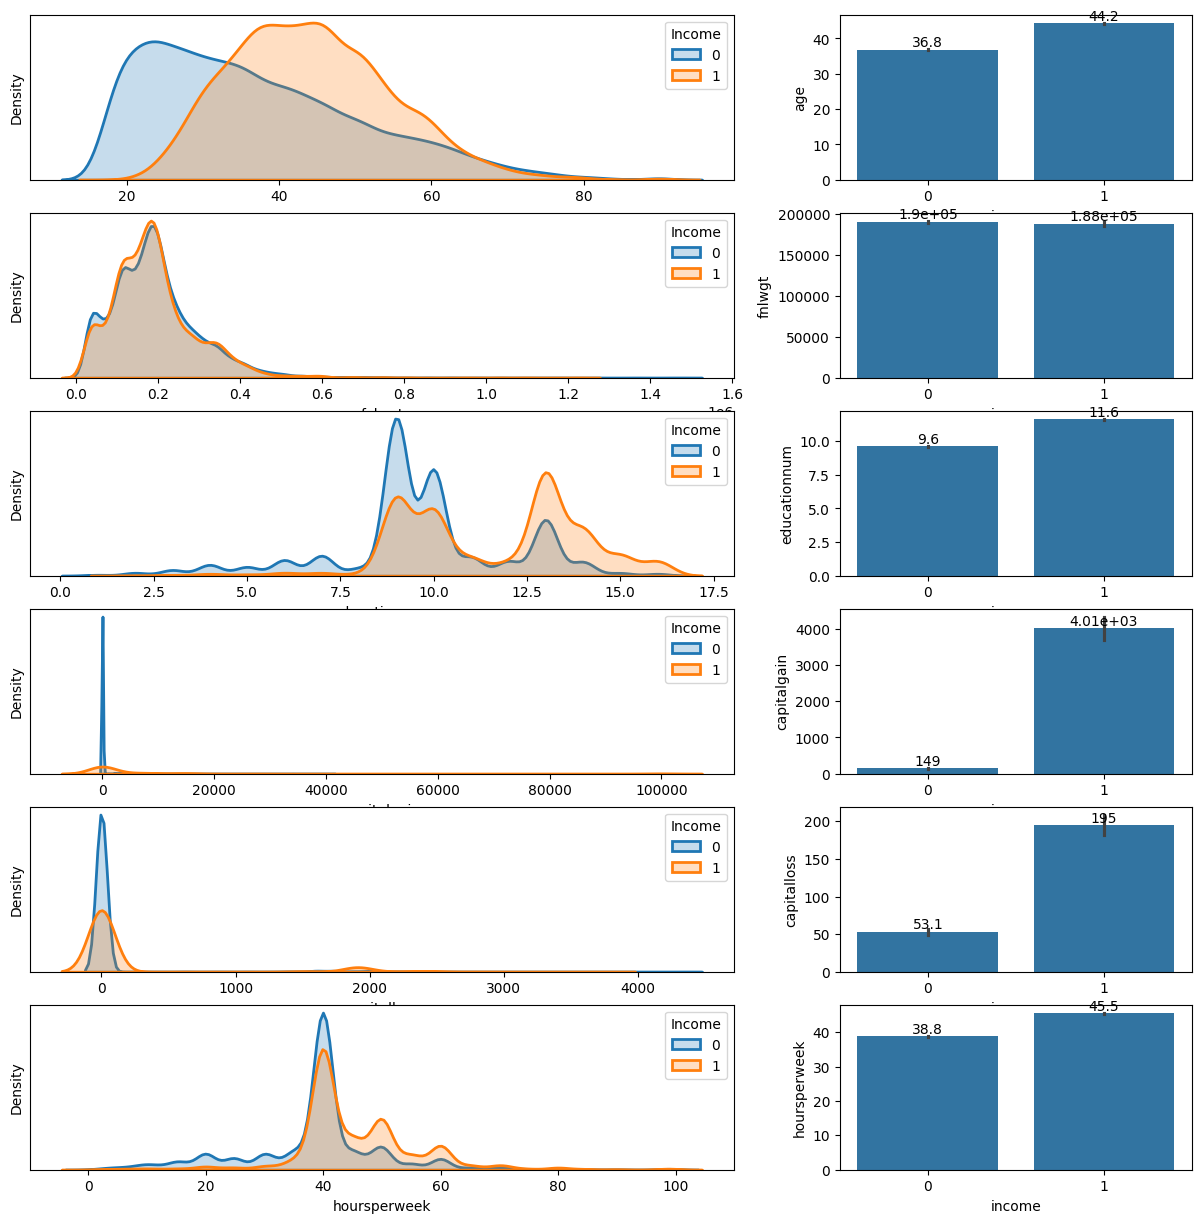

In [58]:
# Function for KDE plot
def kdeplot(col, color):
    kde = stats.gaussian_kde(adult_encoded[col])
    x = np.linspace(adult_encoded[col].min(), income[col].max(), 1000)
    ax[i,0].plot(x, kde(x), color=color)

# create side by side plots for KDE and bar plot
fig, ax = plt.subplots(6, 2, figsize=(15, 15), gridspec_kw={'width_ratios': [2, 1]})
for i,col in enumerate(num_features):
    sns.kdeplot(data=adult_encoded[adult_encoded[target_feature[0]]==0], x=col, fill=True, linewidth=2, ax=ax[i,0], label='0')
    sns.kdeplot(data=adult_encoded[adult_encoded[target_feature[0]]==1], x=col, fill=True, linewidth=2, ax=ax[i,0], label='1')
    proportion = percent_of_total(col)
    graph = sns.barplot(data=adult_encoded, x=target_feature[0], y=col, ax=ax[i,1])
    #graph = sns.countplot(data=adult_encoded, x=col, hue=target_col[0], ax=ax[i,1])
    # Annotate each bar with its value
    # Add values at the center of the bars
    for cont in graph.containers:
        graph.bar_label(cont, fmt='%.3g')
    
    ax[i,0].set_yticks([])
    ax[i,0].legend(title='Income', loc='upper right')
    

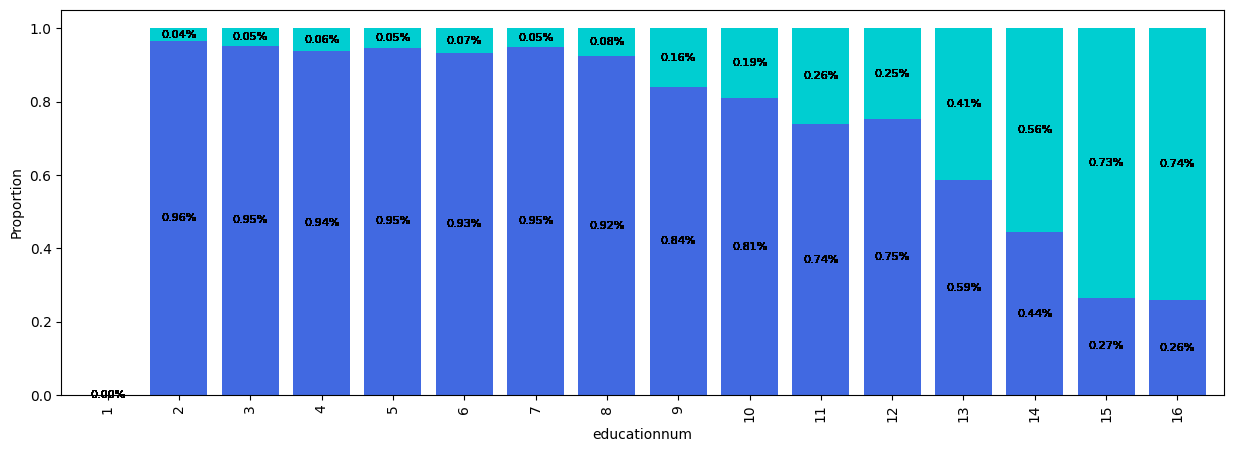

In [59]:

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
proportion = percent_of_total('educationnum')
bars = proportion.plot(kind='bar', ax=ax, stacked=True, width=0.8, colormap=cmp, legend=False, ylabel='Proportion', sharey=True)
for bar_container in bars.containers:
        for bar in bar_container:
            height = bar.get_height()
            # Annotate the bars
            for p in ax.patches:
                width, height = p.get_width(), p.get_height()
                x, y = p.get_xy() 
                ax.annotate(f'{height:.2f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8, color='black')

https://matplotlib.org/3.5.0/tutorials/intermediate/gridspec.html

### Model Training

#### Generalized Linear Model

In [60]:
# Train with generalized linear regression model
model  = smf.glm(formula='income ~ workclass+education+maritalstatus+occupation+relationship+race+sex+nativecountry+age+fnlwgt+educationnum+capitalgain+capitalloss+hoursperweek', family=sm.families.Binomial(), data=adult_encoded).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 income   No. Observations:                32561
Model:                            GLM   Df Residuals:                    32546
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12480.
Date:                Sat, 22 Jun 2024   Deviance:                       24960.
Time:                        14:19:22   Pearson chi2:                 1.61e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2864
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.3708      0.191    -43.829      0.000      -8.745      -7.996
workclass        -0.0217      0.011     -1.930      0.054      -0.044       0.000
education         0.0158      0.005      3.053      0.002       0.006       0.026
maritalstatus    -0.2346      0.012    -19.154      0.000      -0.259      -0.211
occupation        0.0106      0.004      2.724      0.006       0.003       0.018
relationship     -0.1195      0.014     -8.353      0.000      -0.147      -0.091
race              0.1134      0.021      5.322      0.000       0.072       0.155
sex               0.8954      0.050     17.795      0.000       0.797       0.994
nativecountry     0.0034      0.002      1.605      0.109      -0.001       0.008
age               0.0341      0.001     25.197      0.000       0.031       0.037
fnlwgt         5.095e-07   1.52e-07      3.346      0.001    2.11e-07    8.08e-07
educationnum      0.3315      0.007     45.938      0.000       0.317       0.346
capitalgain       0.0003   9.76e-06     32.407      0.000       0.000       0.000
capitalloss       0.0007   3.36e-05     20.222      0.000       0.001       0.001
hoursperweek      0.0299      0.001     21.412      0.000       0.027       0.033
=================================================================================
"""

#### Ensemble Learning

In [81]:
def trainClassifier(X, y, alg):
    if alg == 'en':
        model = VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(random_state=42, max_iter=1000)),  # Increased max_iter
                ('rf', RandomForestClassifier(random_state=42)),
                ('svc', SVC(probability=True, random_state=42))
            ]
        )
        model.fit(X, y)
    elif alg == 'lr':
        model = LogisticRegression(random_state=42, max_iter=1000)  # Increased max_iter
        model.fit(X, y)
    elif alg == 'rf':
        model = RandomForestClassifier(random_state=42)
        model.fit(X, y)
    return model

# Prediction score for voting classifier
def calculatePredictionScore(clf, X, y):
    for name, clf in clf.named_estimators_.items():
        print(name, "=", clf.score(X, y))

In [82]:
# training the model using Ensemble learning (VotingClassifier) without Feature engineering
voting_clf = trainClassifier(X_train, y_train, 'en')
print('Classifier Accuracy of Training set: ')
calculatePredictionScore(voting_clf, X_train, y_train)

/opt/homebrew/Cellar/jupyterlab/4.1.6_1/libexec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier Accuracy of Training set: 
lr = 0.8058968058968059
rf = 1.0
svc = 0.7952242014742015


### Feature Engineering

In [63]:
adult_encoded.head()

,age,workclass,fnlwgt,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


In [64]:
# drop the features with threshold for correlation as 0.1
X_train_drop, X_test_drop = dropFeatures(0.1, adult_encoded)

In [65]:
# training the model using Ensemble learning (VotingClassifier) with feature engineering
voting_clf = trainClassifier(X_train_drop, y_train, 'en')
print('Classifier Accuracy of Training set: ')
calculatePredictionScore(voting_clf, X_train_drop, y_train)

/opt/homebrew/Cellar/jupyterlab/4.1.6_1/libexec/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier Accuracy of Training set: 
lr = 0.792767199017199
rf = 0.9254837223587223
svc = 0.8012899262899262


In [66]:
# Test Prediction
X_test_drop[:1]
[clf.predict(X_test_drop) for clf in voting_clf.estimators_]

[array([1, 0, 0, ..., 1, 0, 0]),
 array([0, 1, 0, ..., 1, 0, 0]),
 array([0, 0, 0, ..., 1, 0, 0])]

In [67]:
print('Classifier Accuracy of Test set: ')
calculatePredictionScore(voting_clf, X_test_drop, y_test)

Classifier Accuracy of Test set: 
lr = 0.7985567326884692
rf = 0.8412405957316137
svc = 0.806540764624597


In [68]:
def plotDecisionBoundary(X_train, X_test, alg):
    # Split data into features and target
    X = adult_encoded.drop('income', axis=1)
    y = adult_encoded['income']

    # prepare data
    X_pca = prepareData(X)

    # Split data into train and test sets
    train_X, test_X, train_y, test_y = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    
    # Train Logistic Regression model
    #model = RandomForestClassifier()
    #model.fit(X_train, y_train)
    model = trainClassifier(train_X, train_y, alg)
    
    # Predict on test data
    y_pred = model.predict(test_X)
    
    # Plot decision boundary
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, edgecolor='k')
    plt.title('Decision Boundary')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

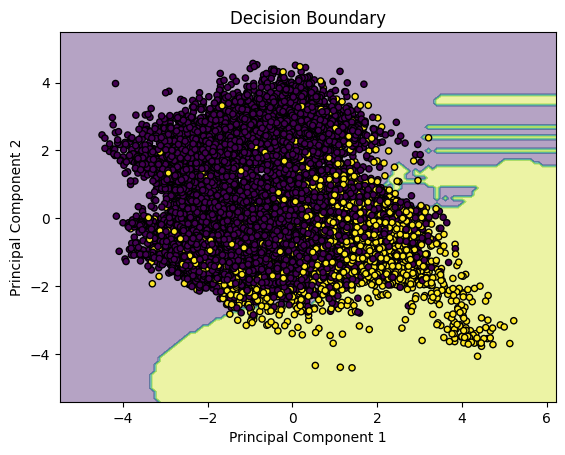

In [69]:
plotDecisionBoundary(X_train_drop, X_test_drop,'en')

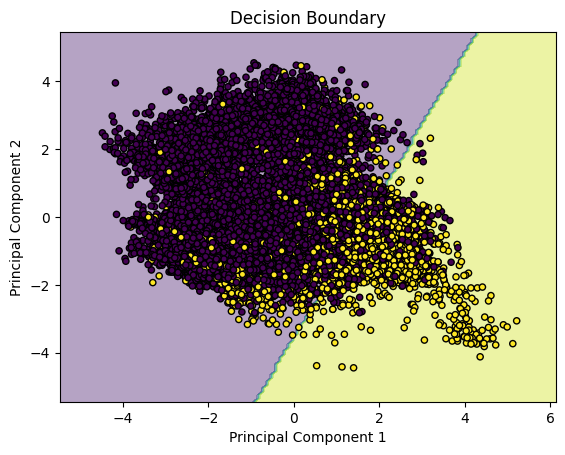

In [70]:
plotDecisionBoundary(X_train, X_test, 'lr')

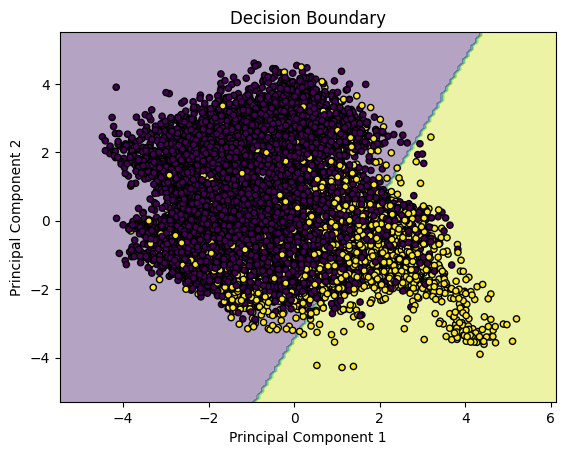

In [71]:
plotDecisionBoundary(X_train, X_test, 'lr')